In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.signal import savgol_filter,find_peaks, welch
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from pathlib import Path

In [ ]:
# timestamp handling and resampling
def resample_clean_timestamp(df, target_hz=10):
    df = df.copy()
    
    # Convert timestamp
    df['timestamp'] = pd.to_datetime(df['Timestamp (s)'], unit='s')
    
    # Check time span before resampling
    time_span = (df['timestamp'].max() - df['timestamp'].min()).total_seconds()
    
    # If time span is unreasonable, use relative timestamps
    if time_span > 3600:  # More than 1 hour - likely timestamp issue
        # Use row index as time base instead
        df['timestamp'] = pd.to_datetime(df.index * 0.1, unit='s')  # Assume 10Hz
        df = df.sort_values('timestamp').reset_index(drop=True)
        return df
    
    # Normal processing for reasonable time spans
    df = df.sort_values('timestamp').reset_index(drop=True)
    df = df.drop_duplicates(subset=['timestamp'], keep='first')
    
    # Only resample if time span is small
    if time_span < 300:  # Less than 5 minutes
        df = df.set_index('timestamp')
        # Resample to 10Hz but only within actual data range
        df_resampled = df.resample('100ms').first()
        # Don't fill all gaps - only interpolate small ones
        df_resampled = df_resampled.interpolate(method='time', limit=3)
        df_resampled = df_resampled.dropna()  # Remove unfilled gaps
        df_resampled = df_resampled.reset_index()
        return df_resampled
    else:
        return df

In [ ]:
# lightweight
def remove_sensor_bias(df):
    sensor_cols = [
        'Accel_X (g)', 'Accel_Y (g)', 'Accel_Z (g)',
        'Gyro_X (°/s)', 'Gyro_Y (°/s)', 'Gyro_Z (°/s)'
    ]
    actual_cols = []
    for col in sensor_cols:
        if col in df.columns:
            actual_cols.append(col)
        else:
            # 尝试其他编码格式
            alt_col = col.replace('°', '�')  # 处理编码问题
            if alt_col in df.columns:
                actual_cols.append(alt_col)
                df = df.rename(columns={alt_col: col})
    # 陀螺仪和加速度计：去除均值偏差
    for col in actual_cols:
        if 'Accel' in col or 'Gyro' in col:
            bias = df[col].mean()
            df[col] = df[col] - bias
            # print(f"Removed bias from {col}: {bias:.4f}")
    return df, actual_cols

In [ ]:
# gravity compensation
def gravity_compensation(df, accel_cols):
    for col in accel_cols:
        gravity_component = df[col].mean()
        df[col] = df[col] - gravity_component
        # print(f"Removed gravity from {col}: {gravity_component:.4f}g")
    return df

In [ ]:
# noise reduction(Savitzky–Golay filter)
def noise_reduction(df, sensor_cols, method='savgol'):
    if method == 'savgol':
        # Savitzky-Golay滤波器 - 保持峰值
        from scipy.signal import savgol_filter
        window_size = 5  # 较小窗口保持峰值
        poly_order = 2
        
        for col in sensor_cols:
            df[col] = savgol_filter(df[col], window_size, poly_order)
    
    elif method == 'moving_average':
        # 移动平均 - 更简单
        window_size = 3
        for col in sensor_cols:
            df[col] = df[col].rolling(window=window_size, center=True).mean()
            df[col] = df[col].fillna(method='bfill').fillna(method='ffill')
    
    return df

In [ ]:
def preprocess_data(csv_path):
    df = pd.read_csv(csv_path, encoding='latin1')
    # 重采样和清理时间戳
    df = resample_clean_timestamp(df, target_hz=10)  
    # 去除传感器偏差
    df, sensor_cols = remove_sensor_bias(df)
    # 重力补偿
    accel_cols = [col for col in sensor_cols if 'Accel' in col]
    df = gravity_compensation(df, accel_cols) 
    # 降噪处理
    df = noise_reduction(df, sensor_cols,  method='savgol')

    output_path = csv_path.replace('.csv', '_preprocessed.csv')
    df.to_csv(output_path, index=False)
    return df, sensor_cols

df_clean, sensors = preprocess_data('./dataset/clear_x30.csv')

In [ ]:
def extract_comprehensive_features(window_data, sensor_cols, sampling_rate=10):
    """
    提取全面的时域、频域和方向变化特征
    
    Parameters:
    - window_data: 窗口数据
    - sensor_cols: 传感器列名
    - sampling_rate: 采样率 (Hz)
    
    Returns:
    - features: 特征向量
    - feature_names: 特征名称列表
    """
    features = []
    feature_names = []

     # 分离传感器数据
    accel_cols = [col for col in sensor_cols if 'Accel' in col]
    gyro_cols = [col for col in sensor_cols if 'Gyro' in col]

    # ========== 时域特征 ==========
    # 1. 每轴的基本统计特征 (Mean, Std, MAD, Min, Max, Range, IQR)
    for sensor_group, group_name in [(accel_cols, 'accel'), (gyro_cols, 'gyro')]:
        for col in sensor_group:
            if col in window_data.columns:
                data = window_data[col].values
                axis_name = col.split('_')[1].lower()  # X, Y, Z
                
                # Mean, Std
                features.extend([np.mean(data), np.std(data)])
                feature_names.extend([f'{group_name}_{axis_name}_mean', f'{group_name}_{axis_name}_std'])
                
                # Median Absolute Deviation
                mad = stats.median_abs_deviation(data, scale='normal')
                features.append(mad)
                feature_names.append(f'{group_name}_{axis_name}_mad')
                
                # Min, Max, Range, IQR
                q1, q3 = np.percentile(data, [25, 75])
                features.extend([np.min(data), np.max(data), np.max(data) - np.min(data), q3 - q1])
                feature_names.extend([
                    f'{group_name}_{axis_name}_min', f'{group_name}_{axis_name}_max', 
                    f'{group_name}_{axis_name}_range', f'{group_name}_{axis_name}_iqr'
                ])
    # 2. 合成幅值特征 |a| 和 |g|
    if len(accel_cols) >= 3:
        accel_mag = np.sqrt(
            window_data[accel_cols[0]]**2 + 
            window_data[accel_cols[1]]**2 + 
            window_data[accel_cols[2]]**2
        )
        features.extend([np.mean(accel_mag), np.std(accel_mag)])
        feature_names.extend(['accel_mag_mean', 'accel_mag_std'])
        
        # Peak count and amplitude for acceleration
        accel_threshold = np.mean(accel_mag) + 0.5 * np.std(accel_mag)
        peaks, peak_props = find_peaks(accel_mag, height=accel_threshold)
        peak_count = len(peaks)
        peak_amplitude = np.mean(peak_props['peak_heights']) if len(peaks) > 0 else 0
        features.extend([peak_count, peak_amplitude])
        feature_names.extend(['accel_peak_count', 'accel_peak_amplitude'])
    if len(gyro_cols) >= 3:
        gyro_mag = np.sqrt(
            window_data[gyro_cols[0]]**2 + 
            window_data[gyro_cols[1]]**2 + 
            window_data[gyro_cols[2]]**2
        )
        features.extend([np.mean(gyro_mag), np.std(gyro_mag)])
        feature_names.extend(['gyro_mag_mean', 'gyro_mag_std'])
        
        # Peak count and amplitude for gyroscope
        gyro_threshold = np.mean(gyro_mag) + 0.5 * np.std(gyro_mag)
        peaks, peak_props = find_peaks(gyro_mag, height=gyro_threshold)
        peak_count = len(peaks)
        peak_amplitude = np.mean(peak_props['peak_heights']) if len(peaks) > 0 else 0
        features.extend([peak_count, peak_amplitude])
        feature_names.extend(['gyro_peak_count', 'gyro_peak_amplitude'])

    #3. Jerk近似 (加速度的一阶差分)
    for i, col in enumerate(accel_cols):
        if col in window_data.columns:
            data = window_data[col].values
            if len(data) > 1:
                jerk = np.diff(data)  # 一阶差分
                axis_name = col.split('_')[1].lower()
                features.extend([np.mean(np.abs(jerk)), np.std(jerk)])
                feature_names.extend([f'jerk_{axis_name}_mean', f'jerk_{axis_name}_std'])
            else:
                # 处理数据太短的情况
                axis_name = col.split('_')[1].lower()
                features.extend([0, 0])
                feature_names.extend([f'jerk_{axis_name}_mean', f'jerk_{axis_name}_std'])

    # ========== 频域特征 ==========
    # 4. 主要频率和功率 (加速度和陀螺仪幅值)
    if len(accel_cols) >= 3 and len(accel_mag) > 1:
        try:
            nperseg = min(len(accel_mag), 16)  # 适应短信号
            freqs, psd = welch(accel_mag, fs=sampling_rate, nperseg=nperseg)
            if len(psd) > 0:
                dominant_freq_idx = np.argmax(psd)
                dominant_freq = freqs[dominant_freq_idx]
                dominant_power = psd[dominant_freq_idx]
                
                # 频带能量 (0.2-1.5 Hz 和 1.5-4 Hz)
                low_band_mask = (freqs >= 0.2) & (freqs <= 1.5)
                mid_band_mask = (freqs > 1.5) & (freqs <= 4.0)
                low_band_energy = np.sum(psd[low_band_mask]) if np.any(low_band_mask) else 0
                mid_band_energy = np.sum(psd[mid_band_mask]) if np.any(mid_band_mask) else 0
                
                features.extend([dominant_freq, dominant_power, low_band_energy, mid_band_energy])
                feature_names.extend(['accel_dominant_freq', 'accel_dominant_power', 
                                    'accel_low_band_energy', 'accel_mid_band_energy'])
            else:
                features.extend([0, 0, 0, 0])
                feature_names.extend(['accel_dominant_freq', 'accel_dominant_power', 
                                    'accel_low_band_energy', 'accel_mid_band_energy'])
        except:
            features.extend([0, 0, 0, 0])
            feature_names.extend(['accel_dominant_freq', 'accel_dominant_power', 
                                'accel_low_band_energy', 'accel_mid_band_energy'])
    
    if len(gyro_cols) >= 3 and len(gyro_mag) > 1:
        try:
            nperseg = min(len(gyro_mag), 16)
            freqs, psd = welch(gyro_mag, fs=sampling_rate, nperseg=nperseg)
            if len(psd) > 0:
                dominant_freq_idx = np.argmax(psd)
                dominant_freq = freqs[dominant_freq_idx]
                dominant_power = psd[dominant_freq_idx]
                
                # 频带能量
                low_band_mask = (freqs >= 0.2) & (freqs <= 1.5)
                mid_band_mask = (freqs > 1.5) & (freqs <= 4.0)
                low_band_energy = np.sum(psd[low_band_mask]) if np.any(low_band_mask) else 0
                mid_band_energy = np.sum(psd[mid_band_mask]) if np.any(mid_band_mask) else 0
                
                features.extend([dominant_freq, dominant_power, low_band_energy, mid_band_energy])
                feature_names.extend(['gyro_dominant_freq', 'gyro_dominant_power', 
                                    'gyro_low_band_energy', 'gyro_mid_band_energy'])
            else:
                features.extend([0, 0, 0, 0])
                feature_names.extend(['gyro_dominant_freq', 'gyro_dominant_power', 
                                    'gyro_low_band_energy', 'gyro_mid_band_energy'])
        except:
            features.extend([0, 0, 0, 0])
            feature_names.extend(['gyro_dominant_freq', 'gyro_dominant_power', 
                                'gyro_low_band_energy', 'gyro_mid_band_energy'])

    # ========== 方向和变化特征 ==========  
    # 5. 短窗口陀螺仪积分幅值 (球拍旋转代理)
    if len(gyro_cols) >= 3 and len(gyro_mag) > 2:
        window_size = max(3, min(5, len(gyro_mag) // 2))  # 短窗口
        gyro_integrated = []
        for i in range(0, len(gyro_mag) - window_size + 1, window_size):
            segment = gyro_mag[i:i + window_size]
            integrated = np.trapz(np.abs(segment)) / sampling_rate  # 积分
            gyro_integrated.append(integrated)
        
        if gyro_integrated:
            features.extend([np.mean(gyro_integrated), np.std(gyro_integrated)])
            feature_names.extend(['gyro_rotation_mean', 'gyro_rotation_std'])
        else:
            features.extend([0, 0])
            feature_names.extend(['gyro_rotation_mean', 'gyro_rotation_std'])
    else:
        features.extend([0, 0])
        feature_names.extend(['gyro_rotation_mean', 'gyro_rotation_std'])
    
    # 6. 轴间相关性
    # 加速度轴间相关性
    if len(accel_cols) >= 3:
        try:
            accel_data = window_data[accel_cols].values
            if accel_data.shape[0] > 1:  # 确保有足够的数据点
                accel_corr = np.corrcoef(accel_data.T)
                # 取上三角矩阵的相关系数
                accel_corr_xy = accel_corr[0, 1] if not np.isnan(accel_corr[0, 1]) else 0
                accel_corr_xz = accel_corr[0, 2] if not np.isnan(accel_corr[0, 2]) else 0
                accel_corr_yz = accel_corr[1, 2] if not np.isnan(accel_corr[1, 2]) else 0
                features.extend([accel_corr_xy, accel_corr_xz, accel_corr_yz])
                feature_names.extend(['accel_corr_xy', 'accel_corr_xz', 'accel_corr_yz'])
            else:
                features.extend([0, 0, 0])
                feature_names.extend(['accel_corr_xy', 'accel_corr_xz', 'accel_corr_yz'])
        except:
            features.extend([0, 0, 0])
            feature_names.extend(['accel_corr_xy', 'accel_corr_xz', 'accel_corr_yz'])
    # 陀螺仪轴间相关性
    if len(gyro_cols) >= 3:
        try:
            gyro_data = window_data[gyro_cols].values
            if gyro_data.shape[0] > 1:
                gyro_corr = np.corrcoef(gyro_data.T)
                gyro_corr_xy = gyro_corr[0, 1] if not np.isnan(gyro_corr[0, 1]) else 0
                gyro_corr_xz = gyro_corr[0, 2] if not np.isnan(gyro_corr[0, 2]) else 0
                gyro_corr_yz = gyro_corr[1, 2] if not np.isnan(gyro_corr[1, 2]) else 0
                features.extend([gyro_corr_xy, gyro_corr_xz, gyro_corr_yz])
                feature_names.extend(['gyro_corr_xy', 'gyro_corr_xz', 'gyro_corr_yz'])
            else:
                features.extend([0, 0, 0])
                feature_names.extend(['gyro_corr_xy', 'gyro_corr_xz', 'gyro_corr_yz'])
        except:
            features.extend([0, 0, 0])
            feature_names.extend(['gyro_corr_xy', 'gyro_corr_xz', 'gyro_corr_yz'])
    
    return np.array(features), feature_names
    


In [ ]:
# use 2s 50% overlapping windows to get exactly 30 windows
def feature_windows(df, sensor_cols, target_windows=30, overlap=0.5, sampling_rate=10, label='clear'):
    data_length = len(df)
    window_size = int(data_length / (target_windows * (1-overlap) + overlap))
    stride = int(window_size * (1 - overlap))
    features, labels = [], []
    for start in range(0, data_length - window_size + 1, stride):
        if len(features) >= target_windows:
            break        
        window = df.iloc[start:start + window_size]
        row_features = []
        for col in sensor_cols:
            if col in window.columns:
                data = window[col]
                row_features.extend([
                    data.mean(), data.std(), data.median(),
                    data.min(), data.max(), data.max() - data.min()
                ])   
        features.append(row_features)
        labels.append(label)  
    return np.array(features), np.array(labels)

clear_features, clear_labels = feature_windows(df_clean, sensors, target_windows=30, overlap=0.5, label='clear')

In [ ]:
def threshold_features(df, sensor_cols, min_windows=30, shot_label='clear', accel_threshold=1.5, min_shot_duration=10, max_shot_duration=50, target_shots=30):
    """
    使用加速度阈值检测动作边界进行windowing   
    Parameters:
    - accel_threshold: 加速度阈值，超过此值认为是动作
    - min_shot_duration: 最小动作持续时间（样本数）
    - max_shot_duration: 最大动作持续时间（样本数）
    - target_shots: 目标动作数量
    """
    accel_cols = [col for col in sensor_cols if 'Accel' in col]
    df['accel_magnitude'] = np.sqrt(
        df[accel_cols[0]]**2 + 
        df[accel_cols[1]]**2 + 
        df[accel_cols[2]]**2
    )
    above_threshold = df['accel_magnitude'] > accel_threshold
    # 找到动作开始和结束点
    shot_segments = []
    in_shot = False
    shot_start = None
    for i, is_active in enumerate(above_threshold):
        if is_active and not in_shot:
            shot_start = i
            in_shot = True
        elif not is_active and in_shot:
            shot_end = i
            shot_duration = shot_end - shot_start        
            # 过滤合理长度的动作
            if min_shot_duration <= shot_duration <= max_shot_duration:
                shot_segments.append((shot_start, shot_end))      
            in_shot = False
    # 处理最后一个动作（如果数据在动作中结束）
    if in_shot and shot_start is not None:
        shot_end = len(df)
        shot_duration = shot_end - shot_start
        if min_shot_duration <= shot_duration <= max_shot_duration:
            shot_segments.append((shot_start, shot_end))

    features, labels = [], []

    for i, (start, end) in enumerate(shot_segments):
        if len(features) >= target_shots:
            break
            
        # 提取动作段
        shot_window = df.iloc[start:end]
        
        # 计算统计特征
        row_features = []
        for col in sensor_cols:
            if col in shot_window.columns:
                data = shot_window[col]
                row_features.extend([
                    data.mean(),           # 均值
                    data.std(),            # 标准差
                    data.median(),         # 中位数
                    data.min(),            # 最小值
                    data.max(),            # 最大值
                    data.max() - data.min() # 范围
                ])
        
        features.append(row_features)
        labels.append(shot_label)
    # 4. 如果检测到的动作不够，使用备用方法
    if len(features) < target_shots:
        # 找到未使用的数据区间，进行补充分割
        used_ranges = set()
        for start, end in shot_segments:
            used_ranges.update(range(start, end))
        unused_data = []
        for i in range(len(df)):
            if i not in used_ranges:
                unused_data.append(i)
        if unused_data and len(features) < target_shots:
            remaining_needed = target_shots - len(features)
            unused_segments = np.array_split(unused_data, remaining_needed)        
            for segment in unused_segments:
                if len(segment) >= min_shot_duration:
                    window = df.iloc[segment]
                    row_features = []
                    for col in sensor_cols:
                        if col in window.columns:
                            data = window[col]
                            row_features.extend([
                                data.mean(), data.std(), data.median(),
                                data.min(), data.max(), data.max() - data.min()
                            ])
                    features.append(row_features)
                    labels.append(shot_label)
    return np.array(features), np.array(labels), shot_segments

In [ ]:
def get_shot_thresholds(shot_label):
    """
    根据动作类型返回合适的阈值
    """
    thresholds = {
        'clear': {'accel': 1.8, 'gyro': 70.0},   # Clear需要高加速度和旋转
        'smash': {'accel': 2.2, 'gyro': 80.0},   # Smash最强烈
        'drive': {'accel': 1.5, 'gyro': 60.0},   # Drive中等强度
        'lift': {'accel': 1.2, 'gyro': 40.0}     # Lift相对温和
    }
    return thresholds.get(shot_label, {'accel': 1.5, 'gyro': 60.0})

def add_fallback_features(df, sensor_cols, shot_segments, shot_label, 
                         existing_features, existing_labels, target_shots, 
                         min_shot_duration, sampling_rate=10):
    """
    备用特征提取方法
    """
    features = existing_features.copy()
    labels = existing_labels.copy()
    
    # 找到未使用的数据区间
    used_ranges = set()
    for start, end in shot_segments:
        used_ranges.update(range(start, end))
    
    unused_data = [i for i in range(len(df)) if i not in used_ranges]
    
    if unused_data and len(features) < target_shots:
        remaining_needed = target_shots - len(features)
        # 方法1: 按运动强度排序选择
        if 'accel_magnitude' in df.columns:
            window_size = 20  # 固定窗口大小
            candidate_windows = []
            
            for i in range(0, len(unused_data) - window_size + 1, window_size//2):
                window_indices = unused_data[i:i+window_size]
                if len(window_indices) >= min_shot_duration:
                    window_data = df.iloc[window_indices]
                    intensity_score = (window_data['accel_magnitude'].max() + 
                                     window_data.get('gyro_magnitude', pd.Series([0])).max())
                    candidate_windows.append((window_indices, intensity_score))           
            # 选择强度最高的窗口
            candidate_windows.sort(key=lambda x: x[1], reverse=True)       
            for window_indices, _ in candidate_windows[:remaining_needed]:
                window = df.iloc[window_indices]
                # 使用全面特征提取
                window_features, _ = extract_comprehensive_features(window, sensor_cols, sampling_rate)
                features.append(window_features)
                labels.append(shot_label)
        
        # 方法2: 简单分割剩余数据
        if len(features) < target_shots:
            remaining_needed = target_shots - len(features)
            unused_segments = np.array_split(unused_data, remaining_needed)   
            for segment in unused_segments:
                if len(segment) >= min_shot_duration:
                    window = df.iloc[segment]
                    # 使用全面特征提取
                    window_features, _ = extract_comprehensive_features(window, sensor_cols, sampling_rate)
                    features.append(window_features)
                    labels.append(shot_label)
    return features, labels

def extract_shot_features(df, sensor_cols, shot_segments, shot_label, target_shots, min_shot_duration, sampling_rate=10):
    """
    从动作片段中提取特征
    """
    features, labels = [], []
    feature_names = None

    # 从检测到的片段提取特征
    for i, (start, end) in enumerate(shot_segments):
        if len(features) >= target_shots:
            break        
        shot_window = df.iloc[start:end]
        
        window_features, names = extract_comprehensive_features(shot_window, sensor_cols, sampling_rate=10)
        print('name', names)
        if feature_names is None:
            feature_names = names

        features.append(window_features)
        labels.append(shot_label)
    # 关键修复：如果没有检测到片段，先生成特征名称
    if feature_names is None:
        print("⚠️  没有检测到有效片段，使用样本窗口生成特征名称")
        # 使用前20行数据作为样本来生成特征名称
        sample_window = df.iloc[:min(20, len(df))]
        _, feature_names = extract_comprehensive_features(sample_window, sensor_cols, sampling_rate)
        print(f"生成了 {len(feature_names)} 个特征名称")
    
    # 备用方法：如果检测到的片段不够
    if len(features) < target_shots:
        features, labels = add_fallback_features(
            df, sensor_cols, shot_segments, shot_label, 
            features, labels, target_shots, min_shot_duration, sampling_rate
        )   
    return features, labels, feature_names

def is_valid_shot_segment(df, start, end, shot_label, accel_threshold, gyro_threshold,
                         min_shot_duration, max_shot_duration):
    """
    验证动作片段是否有效
    """
    duration = end - start
    if not (min_shot_duration <= duration <= max_shot_duration):
        return False
    
    segment = df.iloc[start:end]
    peak_accel = segment['accel_magnitude'].max()
    peak_gyro = segment['gyro_magnitude'].max()
    
    # 根据动作类型设置不同的验证条件
    if shot_label == 'smash':
        return peak_accel > accel_threshold * 0.9
    elif shot_label == 'clear':
        return (peak_accel > accel_threshold * 0.8) or (peak_gyro > gyro_threshold * 0.7)
    elif shot_label == 'drive':
        return peak_accel > accel_threshold * 0.7
    elif shot_label == 'lift':
        return (peak_accel > accel_threshold * 0.6) or (peak_gyro > gyro_threshold * 0.6)
    else:
        return (peak_accel > accel_threshold * 0.7) or (peak_gyro > gyro_threshold * 0.7)

def get_trigger_strategy(df, shot_label, accel_threshold, gyro_threshold):
    """
    根据动作类型选择触发策略
    """
    accel_trigger = df['accel_magnitude'] > accel_threshold
    gyro_trigger = df['gyro_magnitude'] > gyro_threshold
    
    if shot_label == 'smash':
        # Smash: 需要极高的加速度
        return accel_trigger | (df['accel_magnitude'] > accel_threshold * 0.8)
    
    elif shot_label == 'clear':
        # Clear: 加速度和旋转都重要
        combined_intensity = df['accel_magnitude'] + (df['gyro_magnitude'] / 40.0)
        return combined_intensity > (accel_threshold * 1.1)
    
    elif shot_label == 'drive':
        # Drive: 快速但不一定高旋转
        return accel_trigger | (df['accel_magnitude'] > accel_threshold * 0.7)
    
    elif shot_label == 'lift':
        # Lift: 相对温和，任一传感器激活即可
        return accel_trigger | gyro_trigger
    
    else:
        # 默认策略：综合判断
        return accel_trigger | gyro_trigger

def detect_shot_segments(trigger_condition, df, shot_label, 
                         accel_threshold, gyro_threshold, 
                        min_shot_duration, max_shot_duration):
    """
    检测动作片段
    """
    shot_segments = []
    in_shot = False
    shot_start = None
    
    for i, is_active in enumerate(trigger_condition):
        if is_active and not in_shot:
            shot_start = i
            in_shot = True
        elif not is_active and in_shot:
            shot_end = i
            shot_duration = shot_end - shot_start
            
            # 验证片段质量
            if is_valid_shot_segment(df, shot_start, shot_end, shot_label, 
                                   accel_threshold, gyro_threshold, 
                                   min_shot_duration, max_shot_duration):
                shot_segments.append((shot_start, shot_end))
                segment = df.iloc[shot_start:shot_end]
                peak_accel = segment['accel_magnitude'].max()
                peak_gyro = segment['gyro_magnitude'].max()
            in_shot = False
    
    # 处理最后一个片段
    if in_shot and shot_start is not None:
        shot_end = len(df)
        shot_duration = shot_end - shot_start
        if is_valid_shot_segment(df, shot_start, shot_end, shot_label,
                               accel_threshold, gyro_threshold, 
                               min_shot_duration, max_shot_duration):
            shot_segments.append((shot_start, shot_end))
    return shot_segments

def univeral_threshold_windowing(df, sensor_cols, shot_label,accel_threshold=None, gyro_threshold=None, min_shot_duration=8, max_shot_duration=60, target_shots=30):
    """
    通用阈值windowing方法，适用于所有羽毛球动作类型
    
    Parameters:
    - shot_label: 动作类型 ('lift', 'drive', 'smash', 'clear')
    - accel_threshold: 加速度阈值，如果为None则自动设置
    - gyro_threshold: 陀螺仪阈值，如果为None则自动设置
    - min_shot_duration: 最小动作持续时间（样本数）
    - max_shot_duration: 最大动作持续时间（样本数）
    """
    # 1. 根据动作类型自动设置阈值
    if accel_threshold is None or gyro_threshold is None:
        thresholds = get_shot_thresholds(shot_label)
        accel_threshold = accel_threshold or thresholds['accel']
        gyro_threshold = gyro_threshold or thresholds['gyro']
    # 2. 计算传感器幅值
    accel_cols = [col for col in sensor_cols if 'Accel' in col]
    gyro_cols = [col for col in sensor_cols if 'Gyro' in col]

    df['accel_magnitude'] = np.sqrt(
        df[accel_cols[0]]**2 + 
        df[accel_cols[1]]**2 + 
        df[accel_cols[2]]**2
    )
    df['gyro_magnitude'] = np.sqrt(
        df[gyro_cols[0]]**2 + 
        df[gyro_cols[1]]**2 + 
        df[gyro_cols[2]]**2
    )

    # 3. 智能触发检测
    trigger_condition = get_trigger_strategy(df, shot_label, accel_threshold, gyro_threshold)
    # 4. 检测动作片段
    shot_segments = detect_shot_segments(
        trigger_condition, 
        df, 
        shot_label, 
        accel_threshold, 
        gyro_threshold,
        min_shot_duration, 
        max_shot_duration
    )
    # 5. 提取全面特征
    features, labels, feature_names = extract_shot_features(
        df, sensor_cols, shot_segments, shot_label, target_shots,
        min_shot_duration, sampling_rate=10
    )
    return np.array(features), np.array(labels), shot_segments, feature_names


In [263]:
# clear_features_threshold, clear_labels_threshold, shot_segments = threshold_features(
#     df_clean, sensors, 
#     shot_label='clear',
#     min_windows=30, 
#     accel_threshold=1.5, 
#     min_shot_duration=10, 
#     max_shot_duration=50, 
#     target_shots=30
# )
# labels = np.array(['clear'] * len(clear_features_threshold))

clear_features_threshold, clear_labels_threshold, shot_segments, feature_names = univeral_threshold_windowing(
    df_clean, sensors, 
    shot_label='clear',
    target_shots=30
)
print('feature names length:', feature_names)

⚠️  没有检测到有效片段，使用样本窗口生成特征名称
Feature names: ['accel_x (g)_mean', 'accel_x (g)_std', 'accel_x (g)_mad', 'accel_x (g)_min', 'accel_x (g)_max', 'accel_x (g)_range', 'accel_x (g)_iqr', 'accel_y (g)_mean', 'accel_y (g)_std', 'accel_y (g)_mad', 'accel_y (g)_min', 'accel_y (g)_max', 'accel_y (g)_range', 'accel_y (g)_iqr', 'accel_z (g)_mean', 'accel_z (g)_std', 'accel_z (g)_mad', 'accel_z (g)_min', 'accel_z (g)_max', 'accel_z (g)_range', 'accel_z (g)_iqr', 'gyro_x (°/s)_mean', 'gyro_x (°/s)_std', 'gyro_x (°/s)_mad', 'gyro_x (°/s)_min', 'gyro_x (°/s)_max', 'gyro_x (°/s)_range', 'gyro_x (°/s)_iqr', 'gyro_y (°/s)_mean', 'gyro_y (°/s)_std', 'gyro_y (°/s)_mad', 'gyro_y (°/s)_min', 'gyro_y (°/s)_max', 'gyro_y (°/s)_range', 'gyro_y (°/s)_iqr', 'gyro_z (°/s)_mean', 'gyro_z (°/s)_std', 'gyro_z (°/s)_mad', 'gyro_z (°/s)_min', 'gyro_z (°/s)_max', 'gyro_z (°/s)_range', 'gyro_z (°/s)_iqr', 'accel_mag_mean', 'accel_mag_std', 'accel_peak_count', 'accel_peak_amplitude', 'gyro_mag_mean', 'gyro_mag_std', 'gyro_pe

/var/folders/8k/1612g50n30s1w6fy8hm6_sgr0000gn/T/ipykernel_79936/1632834072.py:157: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integrated = np.trapz(np.abs(segment)) / sampling_rate  # 积分
/var/folders/8k/1612g50n30s1w6fy8hm6_sgr0000gn/T/ipykernel_79936/1632834072.py:157: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integrated = np.trapz(np.abs(segment)) / sampling_rate  # 积分
/var/folders/8k/1612g50n30s1w6fy8hm6_sgr0000gn/T/ipykernel_79936/1632834072.py:157: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integrated = np.trapz(np.abs(segment)) / sampling_rate  # 积分
/var/folders/8k/1612g50n30s1w6fy8hm6_sgr0000gn/T/ipykernel_79936/1632834072.py:157: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead,

In [264]:
def save_windowed_features_with_names(features, labels, feature_names, filename):
    """
    保存全面特征，使用实际的特征名称
    """
    print(f"=== 保存特征调试信息 ===")
    print(f"Features shape: {features.shape}")
    print(f"Feature names length: {feature_names}")
    print(f"Labels length: {len(labels)}")
    # 创建DataFrame
    df_features = pd.DataFrame(features, columns=feature_names)
    df_features['label'] = labels
    # 保存到CSV
    df_features.to_csv(filename, index=False)
    return df_features

# clear_windowed_df = save_windowed_features_with_names(
#     clear_features, 
#     clear_labels, 
#     sensors, 
#     'clear_windowed_fixed.csv'
# )
clear_windowed_threshold_df = save_windowed_features_with_names(
    clear_features_threshold, 
    clear_labels_threshold, 
    feature_names, 
    'clear_windowed_threshold_u.csv'
)

=== 保存特征调试信息 ===
Features shape: (30, 72)
Feature names length: ['accel_x (g)_mean', 'accel_x (g)_std', 'accel_x (g)_mad', 'accel_x (g)_min', 'accel_x (g)_max', 'accel_x (g)_range', 'accel_x (g)_iqr', 'accel_y (g)_mean', 'accel_y (g)_std', 'accel_y (g)_mad', 'accel_y (g)_min', 'accel_y (g)_max', 'accel_y (g)_range', 'accel_y (g)_iqr', 'accel_z (g)_mean', 'accel_z (g)_std', 'accel_z (g)_mad', 'accel_z (g)_min', 'accel_z (g)_max', 'accel_z (g)_range', 'accel_z (g)_iqr', 'gyro_x (°/s)_mean', 'gyro_x (°/s)_std', 'gyro_x (°/s)_mad', 'gyro_x (°/s)_min', 'gyro_x (°/s)_max', 'gyro_x (°/s)_range', 'gyro_x (°/s)_iqr', 'gyro_y (°/s)_mean', 'gyro_y (°/s)_std', 'gyro_y (°/s)_mad', 'gyro_y (°/s)_min', 'gyro_y (°/s)_max', 'gyro_y (°/s)_range', 'gyro_y (°/s)_iqr', 'gyro_z (°/s)_mean', 'gyro_z (°/s)_std', 'gyro_z (°/s)_mad', 'gyro_z (°/s)_min', 'gyro_z (°/s)_max', 'gyro_z (°/s)_range', 'gyro_z (°/s)_iqr', 'accel_mag_mean', 'accel_mag_std', 'accel_peak_count', 'accel_peak_amplitude', 'gyro_mag_mean', 'g

In [ ]:
shot_type = ['lift', 'drive', 'smash', 'clear']
dataframes = []
dataset_dir = Path('./dataset')

# Check if dataset directory exists
if not dataset_dir.exists():
    print(f"Error: Dataset directory not found: {dataset_dir.absolute()}")
    print("Please ensure current working directory contains 'dataset' folder")
    raise FileNotFoundError(f"Dataset directory not found: {dataset_dir}")

for shot in shot_type:
    csv_path = dataset_dir / f'{shot}_x30.csv' 
    if not csv_path.exists():
        print(f"Warning: File not found, skipping: {csv_path}")
        continue
    
    # Try different encodings to read CSV files
    loaded = False
    for encoding in ['utf-8', 'gbk', 'gb2312', 'latin1', 'cp1252']:
        try:
            df = pd.read_csv(csv_path, encoding=encoding)
            loaded = True
            break
        except UnicodeDecodeError:
            continue
        except Exception as e:
            print(f"Error reading {csv_path.name} (encoding {encoding}): {e}")
            continue
    if not loaded:
        print(f"Error: Unable to read file {csv_path.name}, tried multiple encodings")
        continue
    
    df['shot_type'] = shot
    dataframes.append(df)

if not dataframes:
    raise FileNotFoundError("No CSV files were successfully loaded. Please check file paths and formats.")

raw_data = pd.concat(dataframes, ignore_index=True)
standard_columns = ['Date', 'Time', 'Accel_X (g)', 'Accel_Y (g)', 'Accel_Z (g)', 'Gyro_X (°/s)', 
'Gyro_Y (°/s)', 'Gyro_Z (°/s)','Mag_X (G)','Mag_Y (G)','Mag_Z (G)','Timestamp (s)', 'shot_type']
raw_data = raw_data[standard_columns]

accel_cols = ['Accel_X (g)', 'Accel_Y (g)', 'Accel_Z (g)']
gyro_cols = ['Gyro_X (°/s)', 'Gyro_Y (°/s)', 'Gyro_Z (°/s)']
mag_cols = ['Mag_X (G)', 'Mag_Y (G)', 'Mag_Z (G)']
sensor_cols = accel_cols + gyro_cols + mag_cols

# timestamp resampling and cleaning
raw_data = resample_clean_timestamp(raw_data, target_hz=10)
# feature extraction
raw_data = remove_sensor_bias(raw_data, accel_cols, gyro_cols, mag_cols)
# raw_data.to_csv('A3_feature_bias.csv', index=False)
# gravity compensation
raw_data = gravity_compensation(raw_data, accel_cols)
raw_data.to_csv('A3_feature_grav.csv', index=False)
# noise reduction
# raw_data = noise_reduction(raw_data, sensor_cols)

# raw_data.to_csv('A3_feature_1.csv', index=False)

In [ ]:
# feacture extraction
features, labels = feature_windows(raw_data, sensor_cols)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# RFC
params_rf = {'n_estimators': [100, 200], 'max_depth': [5, 10], 'min_samples_split': [2, 5], 'max_features': ['auto', 'sqrt']}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), params_rf, scoring='f1_macro', cv=3)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)
print("Random Forest Results:\n", classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf), display_labels=class_labels).plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

✓ Successfully loaded A3_feature.csv
Dataset shape: (2448, 13)
Columns: ['Date', 'Time', 'Accel_X (g)', 'Accel_Y (g)', 'Accel_Z (g)', 'Gyro_X (°/s)', 'Gyro_Y (°/s)', 'Gyro_Z (°/s)', 'Mag_X (G)', 'Mag_Y (G)', 'Mag_Z (G)', 'Timestamp (s)', 'shot_type']

DATASET OVERVIEW
Total records: 2,448
Date range: 2025-10-20 to 2025-10-20
Time range: 12:52:43.082 to 13:13:51.729

SHOT TYPE ANALYSIS
Frequency and Proportion by Shot Type:
----------------------------------------
CLEAR :    618 samples ( 25.2%)
DRIVE :    613 samples ( 25.0%)
LIFT  :    547 samples ( 22.3%)
SMASH :    670 samples ( 27.4%)

TOTAL:  2,448 samples (100.0%)


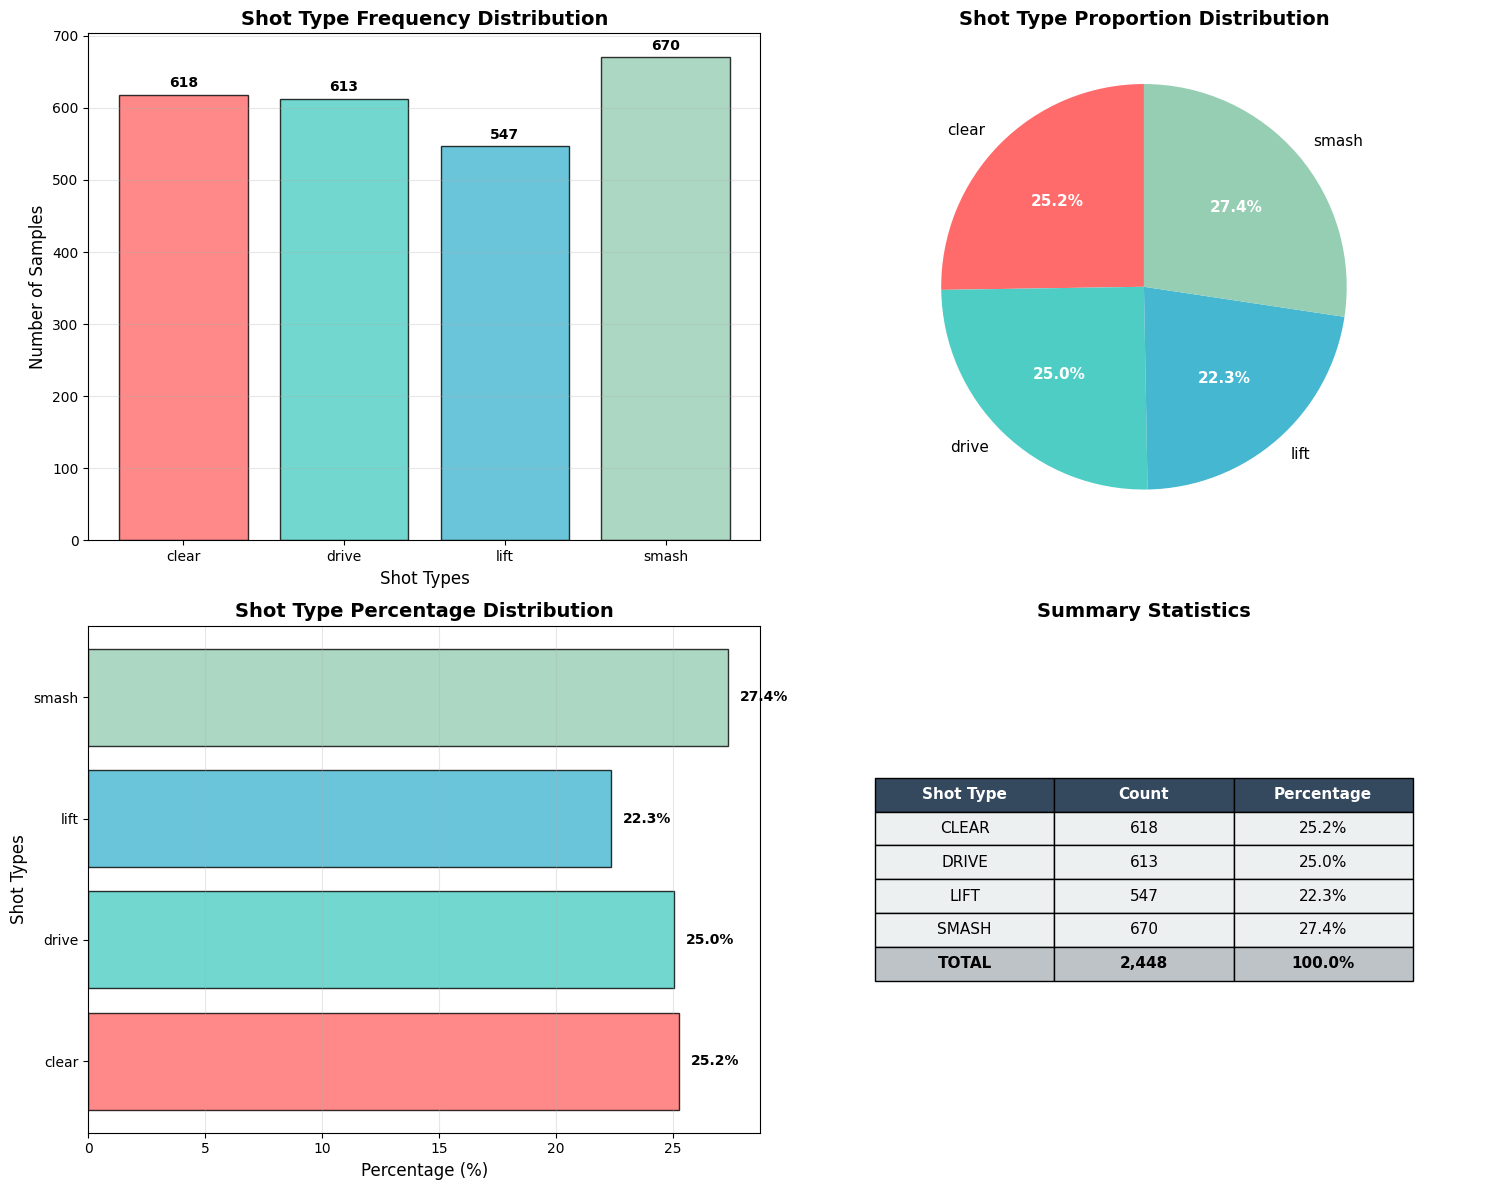


ADDITIONAL STATISTICS
Dataset Balance Analysis:
  • Most frequent shot: smash (670 samples)
  • Least frequent shot: lift (547 samples)
  • Balance ratio (max/min): 1.22
  • Standard deviation: 50.4
  • Coefficient of variation: 8.2%
  ✓ Dataset is well-balanced

Temporal Distribution:
  • Data collection hours: 12:00 - 13:00
  • Peak collection hour: 13:00


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Read the A3_feature.csv file
try:
    df_feature = pd.read_csv('./dataset/A3_feature.csv')
    print("✓ Successfully loaded A3_feature.csv")
    print(f"Dataset shape: {df_feature.shape}")
    print(f"Columns: {list(df_feature.columns)}")
except FileNotFoundError:
    print("❌ A3_feature.csv not found in dataset directory")
    print("Available files:")
    for file in Path('./dataset').glob('*.csv'):
        print(f"  - {file.name}")
    
# Display basic info about the dataset
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(f"Total records: {len(df_feature):,}")
print(f"Date range: {df_feature['Date'].min()} to {df_feature['Date'].max()}")
print(f"Time range: {df_feature['Time'].min()} to {df_feature['Time'].max()}")

# Analyze shot type distribution
print("\n" + "="*50)
print("SHOT TYPE ANALYSIS")
print("="*50)

# Count frequency of each shot type
shot_counts = df_feature['shot_type'].value_counts().sort_index()
shot_proportions = df_feature['shot_type'].value_counts(normalize=True).sort_index() * 100

print("Frequency and Proportion by Shot Type:")
print("-" * 40)
for shot_type in ['clear', 'drive', 'lift', 'smash']:
    count = shot_counts.get(shot_type, 0)
    proportion = shot_proportions.get(shot_type, 0)
    print(f"{shot_type.upper():6}: {count:6,} samples ({proportion:5.1f}%)")

print(f"\nTOTAL: {shot_counts.sum():6,} samples (100.0%)")

# Create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Bar chart of counts
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars1 = ax1.bar(shot_counts.index, shot_counts.values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Shot Type Frequency Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Shot Types', fontsize=12)
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, count in zip(bars1, shot_counts.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 2. Pie chart of proportions
wedges, texts, autotexts = ax2.pie(shot_counts.values, labels=shot_counts.index, 
                                   colors=colors, autopct='%1.1f%%', startangle=90,
                                   textprops={'fontsize': 11})
ax2.set_title('Shot Type Proportion Distribution', fontsize=14, fontweight='bold')

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

# 3. Horizontal bar chart with percentages
bars3 = ax3.barh(shot_counts.index, shot_proportions.values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax3.set_title('Shot Type Percentage Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Percentage (%)', fontsize=12)
ax3.set_ylabel('Shot Types', fontsize=12)
ax3.grid(True, alpha=0.3, axis='x')

# Add percentage labels
for bar, percentage in zip(bars3, shot_proportions.values):
    width = bar.get_width()
    ax3.text(width + 0.5, bar.get_y() + bar.get_height()/2.,
             f'{percentage:.1f}%', ha='left', va='center', fontweight='bold', fontsize=10)

# 4. Statistical summary table
ax4.axis('tight')
ax4.axis('off')

# Create summary statistics
summary_data = []
for shot_type in ['clear', 'drive', 'lift', 'smash']:
    count = shot_counts.get(shot_type, 0)
    proportion = shot_proportions.get(shot_type, 0)
    summary_data.append([shot_type.upper(), f'{count:,}', f'{proportion:.1f}%'])

summary_data.append(['TOTAL', f'{shot_counts.sum():,}', '100.0%'])

table = ax4.table(cellText=summary_data,
                  colLabels=['Shot Type', 'Count', 'Percentage'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0.1, 0.3, 0.8, 0.4])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Style the table
for i in range(len(summary_data) + 1):
    for j in range(3):
        cell = table[(i, j)]
        if i == 0:  # Header row
            cell.set_facecolor('#34495E')
            cell.set_text_props(weight='bold', color='white')
        elif i == len(summary_data):  # Total row
            cell.set_facecolor('#BDC3C7')
            cell.set_text_props(weight='bold')
        else:
            cell.set_facecolor('#ECF0F1')

ax4.set_title('Summary Statistics', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Additional analysis
print("\n" + "="*50)
print("ADDITIONAL STATISTICS")
print("="*50)

# Calculate balance metrics
max_count = shot_counts.max()
min_count = shot_counts.min()
balance_ratio = max_count / min_count if min_count > 0 else float('inf')
std_dev = shot_counts.std()
coefficient_of_variation = (std_dev / shot_counts.mean()) * 100

print(f"Dataset Balance Analysis:")
print(f"  • Most frequent shot: {shot_counts.idxmax()} ({max_count:,} samples)")
print(f"  • Least frequent shot: {shot_counts.idxmin()} ({min_count:,} samples)")
print(f"  • Balance ratio (max/min): {balance_ratio:.2f}")
print(f"  • Standard deviation: {std_dev:.1f}")
print(f"  • Coefficient of variation: {coefficient_of_variation:.1f}%")

if balance_ratio <= 2.0:
    print("  ✓ Dataset is well-balanced")
elif balance_ratio <= 5.0:
    print("  ⚠ Dataset has moderate imbalance")
else:
    print("  ❌ Dataset is significantly imbalanced")

# Time distribution analysis
print(f"\nTemporal Distribution:")
df_feature['hour'] = pd.to_datetime(df_feature['Time'], format='%H:%M:%S.%f').dt.hour
hourly_dist = df_feature.groupby(['hour', 'shot_type']).size().unstack(fill_value=0)
print(f"  • Data collection hours: {df_feature['hour'].min()}:00 - {df_feature['hour'].max()}:00")
print(f"  • Peak collection hour: {df_feature['hour'].mode().iloc[0]}:00")